## Setup

In [1]:
!pip install --user -r requirements.txt

You might need to restart the kernel (Menu -> Kernel -> Restart) to recognise the newly installed packages.

In [2]:
import numpy as np
import scprep
import os
%matplotlib inline

## Loading

We are loading a public 10X dataset containing peripheral blood mononuclear cells (PBMCs). The data comes in the 10X format with a counts matrix (mtx), and gene and cell names (tsv).

In [3]:
data_dir = "data"
os.listdir(data_dir)

['genes.tsv.gz', 'matrix.mtx.gz', 'barcodes.tsv.gz']

In [4]:
# sparse = False makes things run faster at the cost of more memory
data = scprep.io.load_10X(data_dir, gene_labels='both', sparse=True)

In [5]:
data.head(15)

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGGCCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGACAGACC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGATAGTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGCGCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGAGGCATGGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAAGGTTCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAGGATTGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAGGCGATA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATCCCATC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.shape

(4342, 33694)

The data has 4332 rows (cells) and 33694 columns (genes).

## Preprocessing
### Filtering

In [7]:
# remove any genes expressed in less than 10 cells
data_filt = scprep.filter.filter_rare_genes(data, min_cells=10)
data_filt.shape

(4342, 13592)

After filtering, there are 13592 genes remaining.

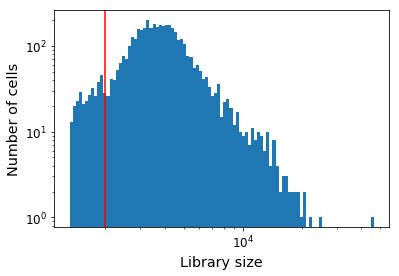

In [8]:
# check the library size distribution
scprep.plot.plot_library_size(data_filt, cutoff=2000)

In [9]:
data_filt = scprep.filter.filter_library_size(data_filt, cutoff=2000)

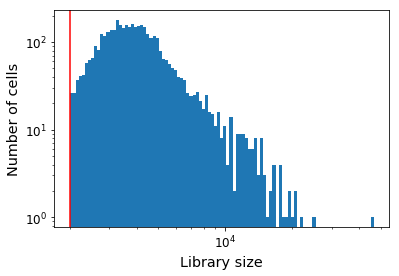

In [10]:
scprep.plot.plot_library_size(data_filt, cutoff=2000)

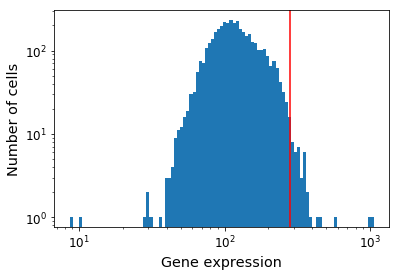

In [11]:
scprep.plot.plot_gene_set_expression(data_filt, starts_with='MT', 
                                     log=True, percentile=99, library_size_normalize=True)

In [12]:
data_filt = scprep.filter.filter_gene_set_expression(data_filt, starts_with='MT', 
                                                     percentile=99, keep_cells='below', 
                                                     library_size_normalize=True)

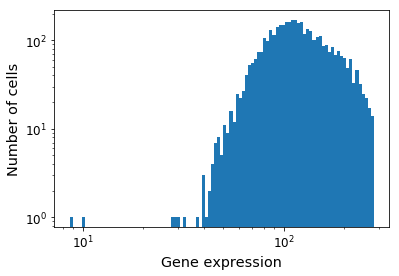

In [13]:
scprep.plot.plot_gene_set_expression(data_filt, starts_with='MT', 
                                     log=True, library_size_normalize=True)

In [14]:
data_filt.shape

(3985, 13592)

### Normalisation

If we look at PCA on this data right now, we will see the primary driver of variation is library size.

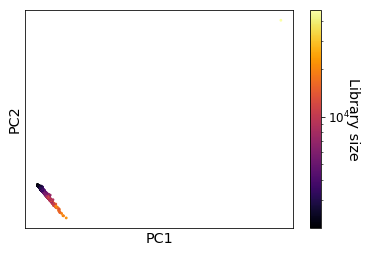

In [15]:
data_pca = scprep.reduce.pca(data_filt, n_components=2)
libsize = scprep.measure.library_size(data_filt)
scprep.plot.scatter2d(data_pca, c=libsize, cmap_scale='log', ticks=False, label_prefix="PC", legend_title='Library size')

Let's normalise the data to account for this.

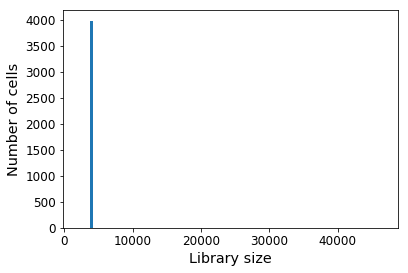

In [16]:
# normalize
data_norm, libsize = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)
# check the library size distribution again
scprep.plot.plot_library_size(data_norm, log=False, range=(np.min(libsize), np.max(libsize)))

### Transformation

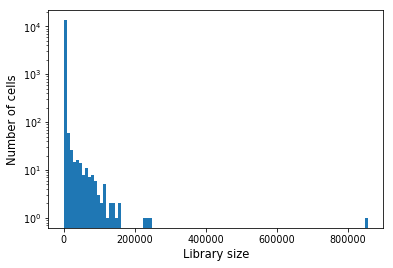

In [17]:
# here's a trick that works because we can simply transpose our matrix
scprep.plot.plot_library_size(data_norm.T, log='y', fontsize=8)
# or: scprep.plot.histogram(data_norm.sum(axis=0))

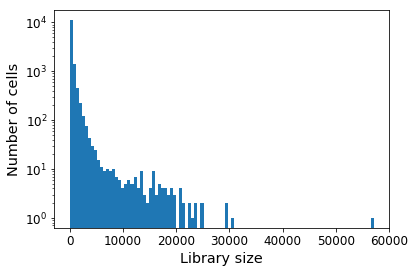

In [18]:
data_sqrt = scprep.transform.sqrt(data_norm)
scprep.plot.plot_library_size(data_sqrt.T, log='y')

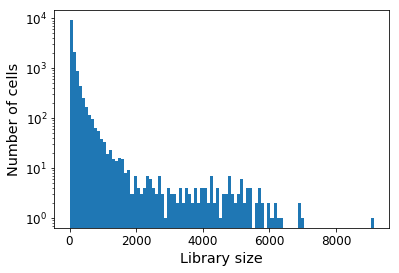

In [19]:
data_log = scprep.transform.log(data_norm)
scprep.plot.plot_library_size(data_log.T, log='y')

Other preprocessing steps people sometimes do:
* use heuristics to select the cutoffs rather than choosing these visually
* remove cells of high library size (as well as low)
* keep only highly variable genes under some statistical model
* use `arcsinh` transformations
* scale all genes to have zero mean and unit variance
* scale all genes to have a fixed range

#### Questions?

## Visualization

In [20]:
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.manifold
import umap
import phate

/home/scottgigante/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
data_pca = sklearn.decomposition.PCA(100).fit_transform(data_sqrt)
# tsne requires you to do PCA first
data_tsne = sklearn.manifold.TSNE().fit_transform(data_pca)
data_umap = umap.UMAP().fit_transform(data_sqrt)
# we will use the graph constructed by PHATE for spectral clustering later
phate_op = phate.PHATE(n_jobs=-1, verbose=0)
data_phate = phate_op.fit_transform(data_sqrt)

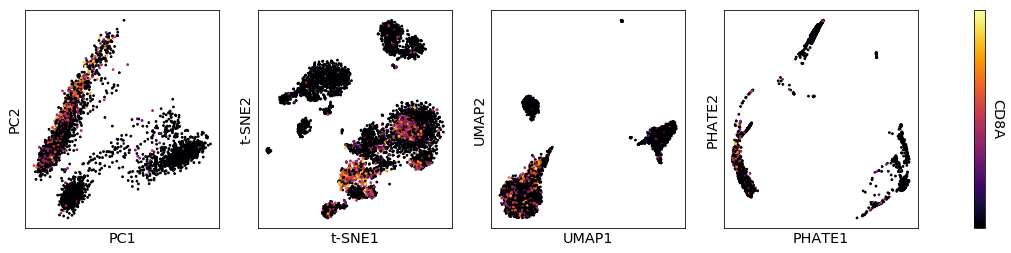

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca, c=scprep.select.select_cols(data_sqrt, exact_word='CD8A'), 
                      ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=scprep.select.select_cols(data_sqrt, exact_word='CD8A'), 
                      ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=scprep.select.select_cols(data_sqrt, exact_word='CD8A'), 
                      ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data_sqrt, exact_word='CD8A'), 
                      ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(cmap='inferno', ax=axes, title='CD8A')

### Imputation

In [37]:
import magic
# ise the phate graph to avoid recomputation
data_magic = magic.MAGIC().fit_transform(data_sqrt, graph=phate_op.graph, 
                                         genes=scprep.select.get_gene_set(data_sqrt, exact_word=['CD8A', 'CD19']))

Calculating MAGIC...
  Running MAGIC on 3985 cells and 13592 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
    Automatically selected t = 7
  Calculated imputation in 0.16 seconds.
Calculated MAGIC in 0.64 seconds.


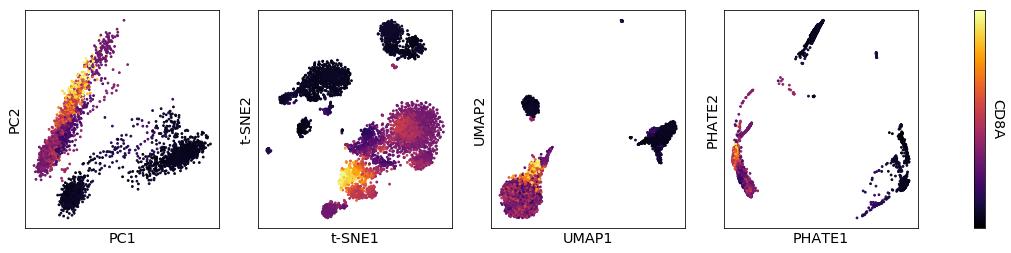

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca, c=scprep.select.select_cols(data_magic, exact_word='CD8A'), 
                      ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=scprep.select.select_cols(data_magic, exact_word='CD8A'), 
                      ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=scprep.select.select_cols(data_magic, exact_word='CD8A'), 
                      ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data_magic, exact_word='CD8A'), 
                      ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(cmap='inferno', ax=axes, title='CD8A')

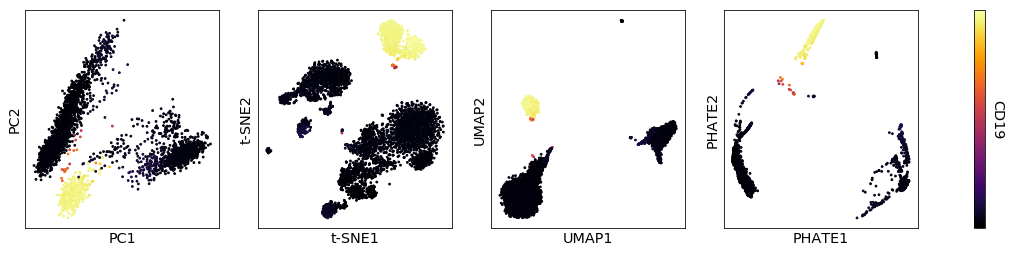

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca, c=scprep.select.select_cols(data_magic, exact_word='CD19'), 
                      ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=scprep.select.select_cols(data_magic, exact_word='CD19'), 
                      ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=scprep.select.select_cols(data_magic, exact_word='CD19'), 
                      ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data_magic, exact_word='CD19'), 
                      ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(cmap='inferno', ax=axes, title='CD19')

Which method is best? Some are better than others, but it depends. When possible, use multiple and check that your conclusions match.

#### Questions?

## Clustering

### _k_-means

In [27]:
import sklearn.cluster
clusters_kmeans = sklearn.cluster.KMeans(7, random_state=42).fit_predict(data_pca)

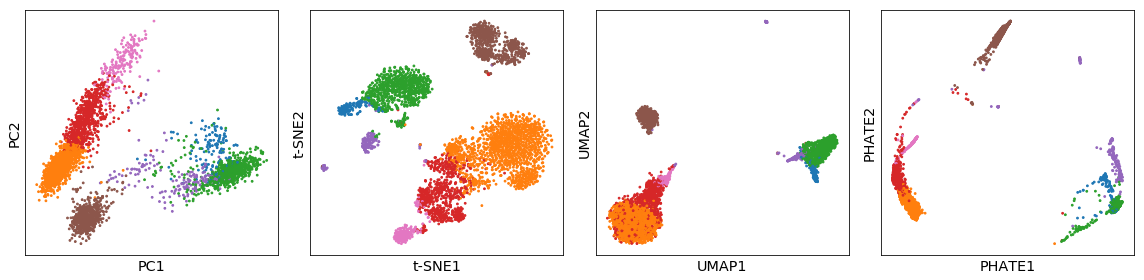

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
scprep.plot.scatter2d(data_pca, c=clusters_kmeans, ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=clusters_kmeans, ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=clusters_kmeans, ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=clusters_kmeans, ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
plt.tight_layout()

### Spectral clustering

In [29]:
clusters_spectral = sklearn.cluster.SpectralClustering(
    7, random_state=42, affinity='precomputed').fit_predict(phate_op.graph.kernel)

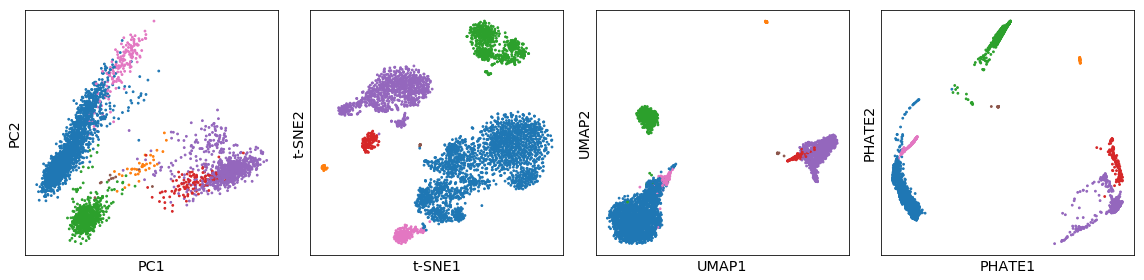

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
scprep.plot.scatter2d(data_pca, c=clusters_spectral, ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=clusters_spectral, ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=clusters_spectral, ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=clusters_spectral, ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
plt.tight_layout()

#### Questions?

## Supervised Learning

In [31]:
data_cd19 = data_sqrt['CD19 (ENSG00000177455)']
data_except_cd19 = scprep.select.select_cols(data_sqrt, regex="^(?!CD19)")
data_except_cd19_pca = sklearn.decomposition.PCA(100).fit_transform(data_except_cd19)

In [40]:
import sklearn.neural_network
nnet_model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(32,16,8), verbose=1)
nnet_model.fit(X=data_except_cd19_pca, y=data_cd19)

Iteration 1, loss = 0.29438123
Iteration 2, loss = 0.10048836
Iteration 3, loss = 0.07242450
Iteration 4, loss = 0.06100103
Iteration 5, loss = 0.05406331
Iteration 6, loss = 0.04919256
Iteration 7, loss = 0.04547623
Iteration 8, loss = 0.04260767
Iteration 9, loss = 0.04019162
Iteration 10, loss = 0.03817122
Iteration 11, loss = 0.03651344
Iteration 12, loss = 0.03509269
Iteration 13, loss = 0.03396567
Iteration 14, loss = 0.03284931
Iteration 15, loss = 0.03192092
Iteration 16, loss = 0.03091520
Iteration 17, loss = 0.03012233
Iteration 18, loss = 0.02934146
Iteration 19, loss = 0.02853479
Iteration 20, loss = 0.02782834
Iteration 21, loss = 0.02707680
Iteration 22, loss = 0.02645445
Iteration 23, loss = 0.02584748
Iteration 24, loss = 0.02523205
Iteration 25, loss = 0.02476262
Iteration 26, loss = 0.02404132
Iteration 27, loss = 0.02352847
Iteration 28, loss = 0.02316115
Iteration 29, loss = 0.02258671
Iteration 30, loss = 0.02212034
Iteration 31, loss = 0.02173930
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(32, 16, 8), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
cd19_predicted = nnet_model.predict(data_except_cd19_pca)

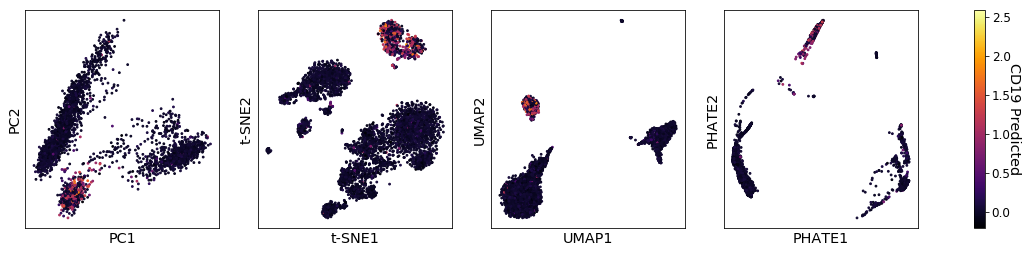

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca, c=cd19_predicted, ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=cd19_predicted, ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=cd19_predicted, ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=cd19_predicted, ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(vmin=np.min(cd19_predicted), vmax=np.max(cd19_predicted), cmap='inferno', ax=axes, title='CD19 Predicted')

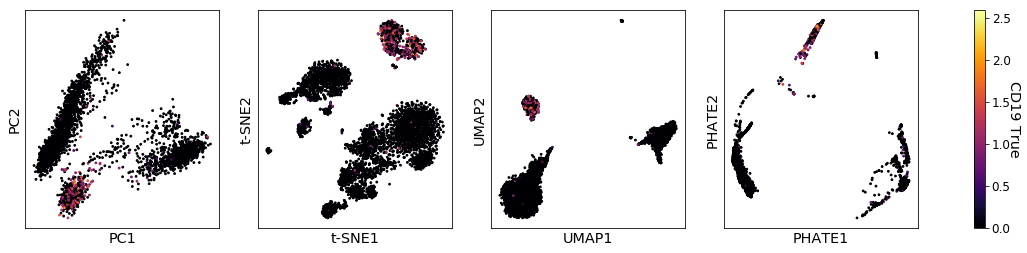

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca, c=data_cd19, ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne, c=data_cd19, ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap, c=data_cd19, ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate, c=data_cd19, ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(vmin=np.min(data_cd19), vmax=np.max(data_cd19), cmap='inferno', ax=axes, title='CD19 True')

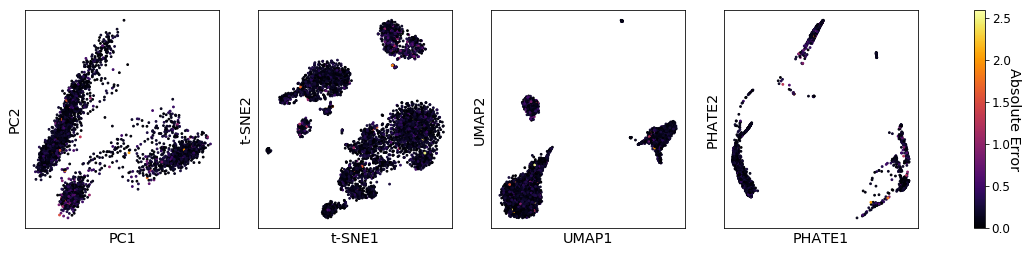

In [44]:
error = np.abs(cd19_predicted - data_cd19)
order = np.argsort(error)
np.random.seed(42)
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
scprep.plot.scatter2d(data_pca[order], c=error[order], ax=axes[0], label_prefix="PC", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_tsne[order], c=error[order], ax=axes[1], label_prefix="t-SNE", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_umap[order], c=error[order], ax=axes[2], label_prefix="UMAP", 
                      ticks=False, legend=False)
scprep.plot.scatter2d(data_phate[order], c=error[order], ax=axes[3], label_prefix="PHATE", 
                      ticks=False, legend=False)
scprep.plot.tools.generate_colorbar(vmin=np.min(data_cd19), vmax=np.max(data_cd19), cmap='inferno', ax=axes, title='Absolute Error')

#### Questions?